Particle distributions in beams and bunches are represented with the `Particles` class. This notebook shows how to generate and instantiate the distributions. Special attention is given to the longitudinal phase space initialisation.

# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PyHEADTAIL imports

In [3]:
import pycuda.autoinit

from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems, LinearMap
import PyHEADTAIL.cobra_functions.stats as st

PyHEADTAIL v1.13.0




# Setting up the machine and functions

In [4]:
# general simulation parameters
n_particles = 10000

# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 5. # in [m]
inj_beta_y = 31. # in [m]
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focusing phase (0 or pi)

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]
sigma_z = 11.8086654962 # in [m]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
print ('beta: ' + str(beta))
eta = alpha_c_array[0] - gamma**-2
print ('eta: ' + str(eta))
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
print ('Q_s: ' + str(Qs))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
# sigma_z = np.sqrt(beta_z * e * epsn_z / (4. * np.pi * p0)) # linear calculation ~ 11.56 m

beta: 0.9159610083509163
eta: -0.10004911507
Q_s: 0.00025482215048808926


In [5]:
def plot_phase_space(bunch):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
    # phase spaces
    ax0.scatter(bunch.x, bunch.xp)
    ax0.set_xlim([min(bunch.x), max(bunch.x)])
    ax0.set_ylim([min(bunch.xp), max(bunch.xp)])
    ax0.set_title('$x-x\'\,$ phase space', fontsize=20)
    ax1.scatter(bunch.y, bunch.yp)
    ax1.set_xlim([min(bunch.y), max(bunch.y)])
    ax1.set_ylim([min(bunch.yp), max(bunch.yp)])
    ax1.set_title('$y-y\'\,$ phase space', fontsize=20)
    ax2.scatter(bunch.z, bunch.dp)
    ax2.set_xlim([min(bunch.z), max(bunch.z)])
    ax2.set_ylim([min(bunch.dp), max(bunch.dp)])
    ax2.set_title('$z-\delta p\,$ phase space', fontsize=20)
    # statistical quantities
    ax0.scatter(bunch.mean_x(), bunch.mean_xp(), color='red')
    ax1.scatter(bunch.mean_y(), bunch.mean_yp(), color='red')
    ax2.scatter(bunch.mean_z(), bunch.mean_dp(), color='red')
    plt.tight_layout()
    plt.show()

def plot_long_phase_space(bunch_new, rfbucket, margin=None):
    z = np.linspace(*rfbucket.interval, num=100)
    dp = np.linspace(-0.006, 0.006, num=100)
    ZZ, DPP = np.meshgrid(z, dp)
    HH = rfbucket.hamiltonian(ZZ, DPP)
    plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
    plt.colorbar()
    plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
    if margin:
        plt.contour(ZZ, DPP, HH, levels=[rfbucket.h_sfp()*margin], colors='r', linewidths=2)
    plt.scatter(bunch_new.z, bunch_new.dp)

# Let's go

### Generate Gaussian phase space distributions

Particle instances are bunches or beams with a 6-dimensional phase space macro-particle distribution in the generalised Frenet-Serret coordinates and their momenta $(x,x',y,y',z,\delta p)$. To generate a distribution, the `ParticleGenerator` base class is used. Provide it with distribution functions for the horizontal, vertical and longitudinal planes. In this case we use bi-Gaussian distributions via `gaussian2D` which are initialised with geometric emittances (i.e. without the normalisation $\beta\gamma$ factor and the conventional longitudinal $e/(4\pi)$ factor). The resulting Floquet space distributions are automatically "matched" to the given optics resp. longitudinal parameters:

geometrical horizontal emittance: 1.0952084144812207e-06
geometrical vertical emittance: 1.0952084144812207e-06
geometrical longitudinal emittance: 0.013366572370478051


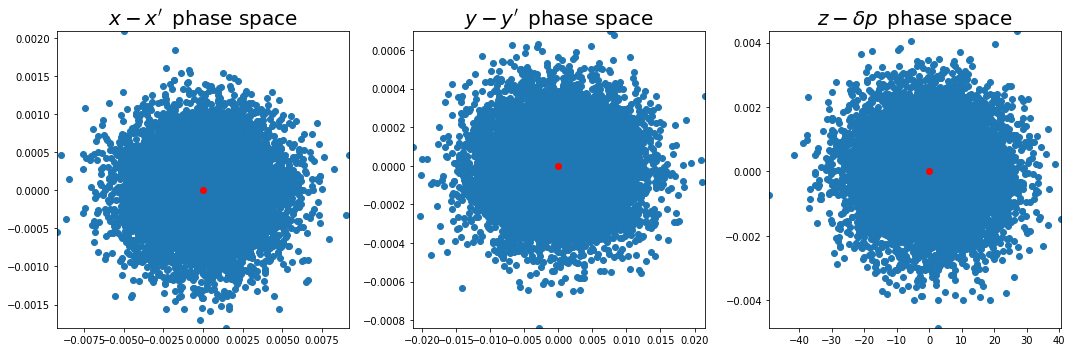

emittance x new: 2.5104588994405944e-06 (nominal value: 2.5e-06)
emittance y new: 2.4895654859481864e-06 (nominal value: 2.5e-06)
emittance z new: 1.2120826114136034 (nominal value: 1.2)


In [6]:
egeox = epsn_x/(beta*gamma)
egeoy = epsn_y/(beta*gamma)
egeoz = epsn_z*e/(4*np.pi*p0)
print ('geometrical horizontal emittance:', egeox)
print ('geometrical vertical emittance:', egeoy)
print ('geometrical longitudinal emittance:', egeoz)
bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.gaussian2D(egeox), 
    alpha_x=inj_alpha_x, beta_x=inj_beta_x,
    distribution_y=generators.gaussian2D(egeoy), 
    alpha_y=inj_alpha_y, beta_y=inj_beta_y,
    distribution_z=generators.gaussian2D(egeoz), 
    Qs=Qs, eta=eta).generate()

plot_phase_space(bunch_new)

print ('emittance x new:', bunch_new.epsn_x(), 
       '(nominal value: {0:.3g})'.format(epsn_x))
print ('emittance y new:', bunch_new.epsn_y(), 
       '(nominal value: {0:.3g})'.format(epsn_y))
print('emittance z new:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})'.format(epsn_z))

For convenience, the `Gaussian6DTwiss` function initialises a bunch with the same bi-Gaussian distributions for each plane as the previous example hence avoiding unnecessary clutter. In principle, the general ParticleGenerator interface allows other distributions, too (such as the Kapchinskij-Vladimirskij distribution `kv2D` or `kv4D`). 

Note that we include dispersion here (requiring the longitudinal phase space to be initialised, i.e. the kwarg `distribution_z` must be provided):

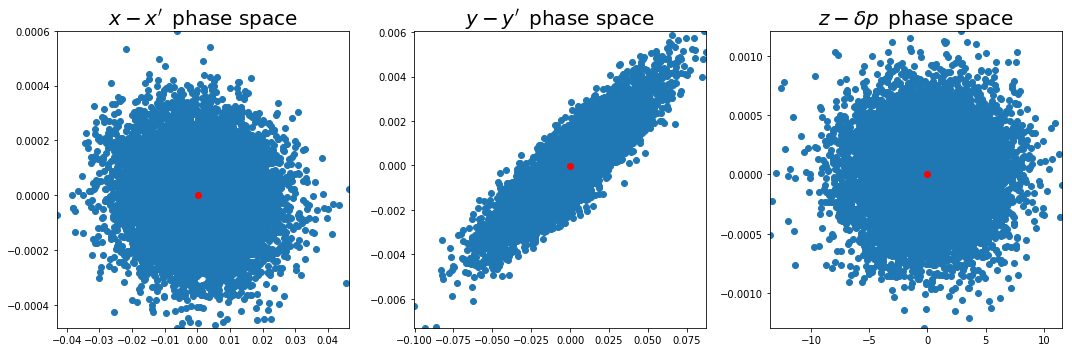

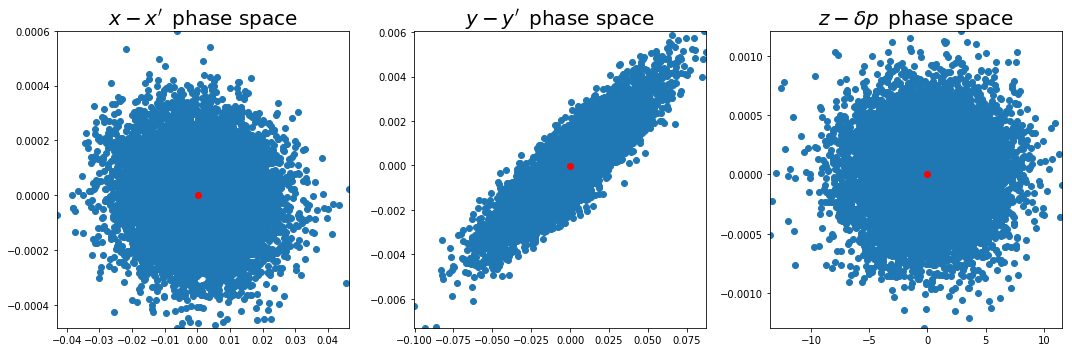

In [7]:
# Check the convenience functions. With the same seed, they give exactly the same:
np.random.seed(1)
bunch1 = generators.generate_Gaussian6DTwiss(n_particles, intensity,
        e, m_p, circumference, gamma,
        alpha_x=0.1, alpha_y=-1.9, beta_x=81.1, beta_y=31.2,
        beta_z=beta_z, epsn_x=3.75e-6, epsn_y=4.2e-5, epsn_z=0.1, # note: normalised emittances!
        dispersion_x=1, dispersion_y=-2.5)

np.random.seed(1)
bunch2 = generators.ParticleGenerator(n_particles, intensity,
             e, m_p, circumference, gamma, # here we need the geometrical emittances:
             distribution_x=generators.gaussian2D(3.75e-6/(gamma*beta)), alpha_x=0.1, beta_x=81.1, D_x=1,
             distribution_y=generators.gaussian2D(4.2e-5/(gamma*beta)), alpha_y=-1.9, beta_y=31.2, D_y=-2.5,
             distribution_z=generators.gaussian2D(0.1*e/(4*np.pi*p0)), Qs=Qs, eta=eta).generate()

plot_phase_space(bunch1)
plot_phase_space(bunch2)

Per se, initialising the full 6D phase space is not mandatory e.g. in the case of mere transverse tracking without dispersion and chromaticity. Also, we can only track the longitudinal plane e.g. with the linear tracking module, transverse effects (such as subtracting and re-adding the dispersion contribution) will be ignored then -- note the warning.

Check that the emittance remains constant over a few turns:

In [8]:
# create a longitudinal only beam and track it, see if emittance grows ...
bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=generators.gaussian2D(egeoz), 
    Qs=Qs, eta=eta).generate()

longitudinal = LinearMap(alpha_c_array, circumference, Qs)
for turn in range(5):
    print ('\nturn', turn)
    print ('current emittance z:', bunch_new.epsn_z())
    longitudinal.track(bunch_new)


turn 0
current emittance z: 1.1871399650791725
*** PyHEADTAIL WARNING! Failed to apply transverse dispersion correction during longitudinal tracking. Caught AttributeError: 
'Particles' object has no attribute 'x'
Continue without adjusting dispersion contribution when changing beam.dp...

turn 1
current emittance z: 1.1871399650791725

turn 2
current emittance z: 1.1871399650791865

turn 3
current emittance z: 1.187139965079183

turn 4
current emittance z: 1.187139965079189


### Importing arrays with already distributed macro-particle coordinates and momenta

Loading a new `Particles` instance with pre-defined coordinate and momentum arrays is possible with the `import_distribution2D` function:

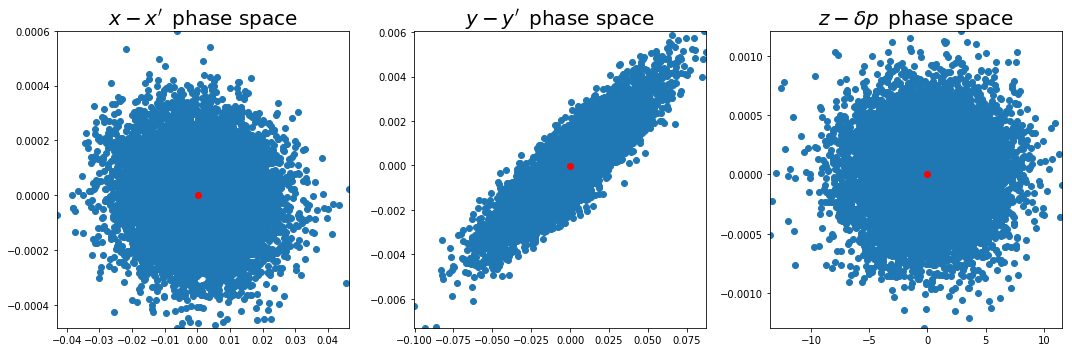

In [9]:
bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.import_distribution2D([bunch1.x, bunch1.xp]),
    distribution_y=generators.import_distribution2D([bunch1.y, bunch1.yp]),
    distribution_z=generators.import_distribution2D([bunch1.z, bunch1.dp])
).generate()

plot_phase_space(bunch_new)     

The coordinate and momentum arrays of the new `Particles` instance have been copied and can be tracked separately from the initially provided arrays:

In [10]:
print ('All entries of the initial and new bunch x coordinate array are the same:', 
       np.all(bunch1.x == bunch_new.x))
print ('The initial and new bunch x coordinate array are not identical though:', 
       bunch1.x is not bunch_new.x)
print ('\nMemory location of the initial coordinate array:', object.__repr__(bunch1.x))
print ('Memory location of the new coordinate array:    ', object.__repr__(bunch_new.x))

All entries of the initial and new bunch x coordinate array are the same: True
The initial and new bunch x coordinate array are not identical though: True

Memory location of the initial coordinate array: <numpy.ndarray object at 0x7f3b6dd67490>
Memory location of the new coordinate array:     <numpy.ndarray object at 0x7f3b6c381d00>


### Generating uniform distributions

The `uniform2D` function initialises the macro-particle coordinate with a uniform distribution, the momentum remains zero.

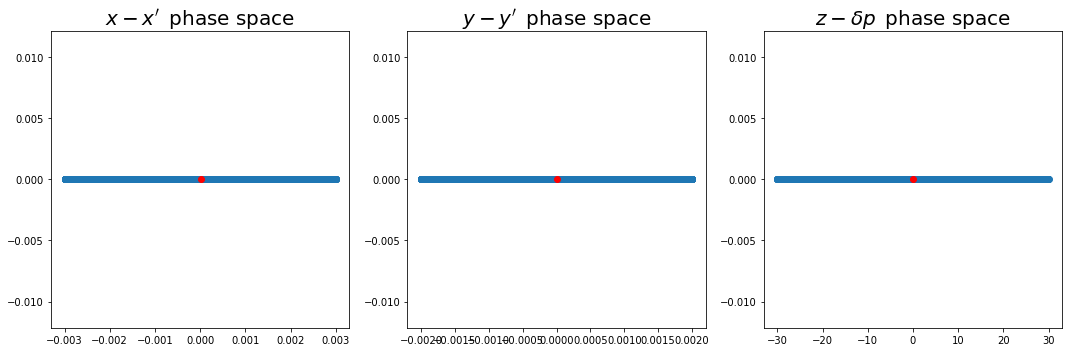

In [11]:
bunch = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.uniform2D(-3e-3, 3e-3),
    distribution_y=generators.uniform2D(-2e-3, 2e-3),
    distribution_z=generators.uniform2D(-30, 30)
).generate()

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
# phase spaces
ax0.scatter(bunch.x, bunch.xp)
ax0.set_xlim([1.1*min(bunch.x), 1.1*max(bunch.x)])
ax0.set_title('$x-x\'\,$ phase space', fontsize=20)
ax1.scatter(bunch.y, bunch.yp)
ax1.set_xlim([1.1*min(bunch.y), 1.1*max(bunch.y)])
ax1.set_title('$y-y\'\,$ phase space', fontsize=20)
ax2.scatter(bunch.z, bunch.dp)
ax2.set_xlim([1.1*min(bunch.z), 1.1*max(bunch.z)])
ax2.set_title('$z-\delta p\,$ phase space', fontsize=20)
# statistical quantities
ax0.scatter(bunch.mean_x(), bunch.mean_xp(), color='red')
ax1.scatter(bunch.mean_y(), bunch.mean_yp(), color='red')
ax2.scatter(bunch.mean_z(), bunch.mean_dp(), color='red')
plt.tight_layout()
plt.show()

### Matching to non-linear radio frequency bucket

The longitudinal plane can be initialised being matched to a non-linear radio frequency bucket.

In [12]:
rfsystems = RFSystems(circumference, [harmonic], [V_rf], [phi_offset],
                      alpha_c_array, gamma, mass=m_p, charge=e)

rfbucket = rfsystems.get_bucket(gamma=gamma)

For large longitudinal emittances approaching the bucket area, the corresponding distribution differs from matching to the linear longitudinal parameters $Q_S$ and $\eta$. PyHEADTAIL currently offers two methods to initialise a thermalised (Gaussian-like) distribution to a given `RFBucket` instance via

1. the normalised longitudinal emittance $\epsilon_z$ (in eVs) and
2. the root mean square bunch length $\sigma_z$ (in m).

The first method uses the kwarg `epsn_z` in `RF_bucket_distribution`:

*** Maximum RMS emittance 4.505891675377581eV s.
... distance to target emittance: -1.19e+00
... distance to target emittance: 2.78e+00
... distance to target emittance: 1.45e+00
... distance to target emittance: 1.09e-01
... distance to target emittance: -5.53e-03
... distance to target emittance: 1.60e-06
... distance to target emittance: -4.74e-06
--> Emittance: 1.2000016025417657
--> Bunch length: 11.8086739325653

emittance z: 1.1836790373222934 (nominal value: 1.2)


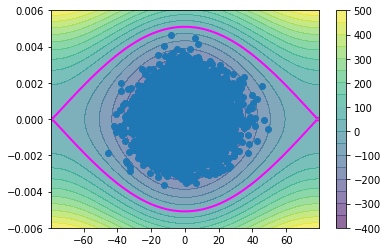

In [13]:
distribution_z = generators.RF_bucket_distribution(
    rfbucket, epsn_z=epsn_z)

bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=distribution_z
).generate()

plot_long_phase_space(bunch_new, rfbucket)

print('\nemittance z:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})'.format(epsn_z))

The second method uses the kwarg `sigma_z` in `RF_bucket_distribution`. The kwargs `sigma_z` and `epsn_z` are mutually exclusive. Based on the given longitudinal parameters (RF frequency, voltage and slippage factor $\eta$), the above used longitudinal emittance of $\epsilon_z=1.2~\text{eVs}$ corresponds to an RMS bunch length of $\sigma_z\approx 11.8~\text{m}$:

*** Maximum RMS bunch length 24.67952104635068m.


/home/oeftiger/anaconda2-2018-11/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


... distance to target bunch length: -1.1691e+01
... distance to target bunch length: 1.2249e+01
... distance to target bunch length: 9.7874e+00
... distance to target bunch length: 2.5029e+00
... distance to target bunch length: -1.2015e+00
... distance to target bunch length: -7.8938e-03
... distance to target bunch length: 7.3213e-05
... distance to target bunch length: -4.3514e-09
--> Bunch length: 11.808665491848602
--> Emittance: 1.2000000006945226

emittance z: 1.2029633124091528 (nominal value: 1.2)


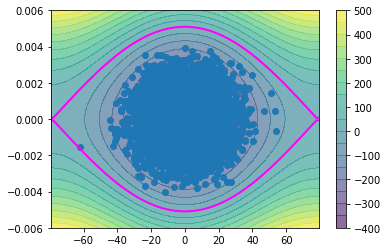

In [14]:
distribution_z = generators.RF_bucket_distribution(
    rfbucket, sigma_z=sigma_z)

bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=distribution_z
).generate()

plot_long_phase_space(bunch_new, rfbucket)

print('\nemittance z:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})'.format(epsn_z))

### Updating an existing `Particles` instance with new coordinates and momenta

The `ParticleGenerator` class can also simply update an existing `Particles` instance instead of generating a new one. This way, the coordinates and momenta of the existing beam get overwritten, e.g. when reloading the longitudinal phase space:

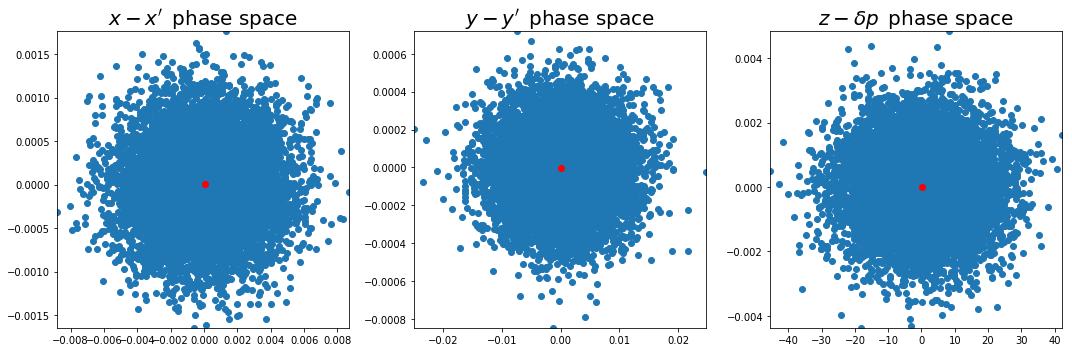

emittance x: 2.5139026230577715e-06 (nominal value: 2.5e-06)
emittance y: 2.461720447682134e-06 (nominal value: 2.5e-06)
emittance z [linear init]: 1.1979645157533045 (nominal value: 1.2)


*** Maximum RMS emittance 4.505891675377581eV s.
... distance to target emittance: -1.19e+00
... distance to target emittance: 2.78e+00
... distance to target emittance: 1.45e+00
... distance to target emittance: 1.09e-01
... distance to target emittance: -5.53e-03
... distance to target emittance: 1.60e-06
... distance to target emittance: -4.74e-06
--> Emittance: 1.2000016025417657
--> Bunch length: 11.8086739325653


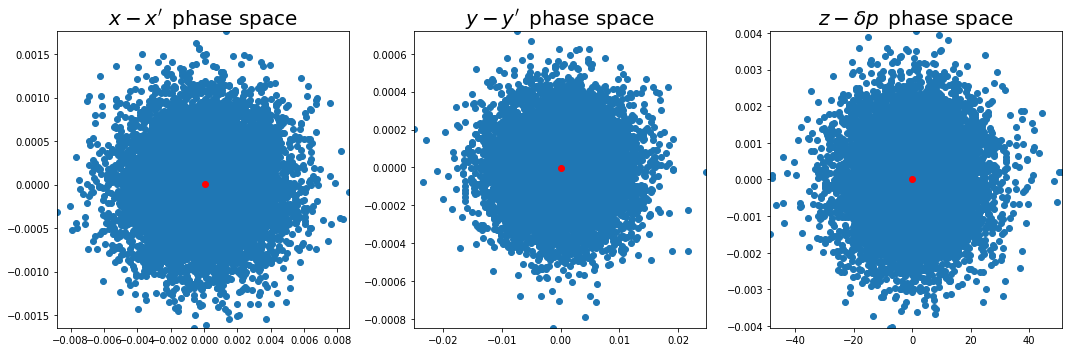

emittance z new [matched to RF now]: 1.1916671514792954


In [15]:
# create an initial beam:
bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.gaussian2D(egeox),
    alpha_x=inj_alpha_x, beta_x=inj_beta_x,
    distribution_y=generators.gaussian2D(egeoy),
    alpha_y=inj_alpha_y, beta_y=inj_beta_y,
    distribution_z=generators.gaussian2D(egeoz), Qs=Qs, eta=eta
).generate()

plot_phase_space(bunch_new)

print ('emittance x:', bunch_new.epsn_x(), 
       '(nominal value: {0:.3g})'.format(epsn_x))
print ('emittance y:', bunch_new.epsn_y(), 
       '(nominal value: {0:.3g})'.format(epsn_y))
print('emittance z [linear init]:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})\n\n'.format(epsn_z))

# reload this beam's longitudinal phase space:
generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=generators.RF_bucket_distribution(
        rfsystems.get_bucket(gamma=gamma), epsn_z=epsn_z),
).update(bunch_new)

plot_phase_space(bunch_new)

print('emittance z new [matched to RF now]:', bunch_new.epsn_z())

### Impose bounds on macro-particle generation domains

One might want to impose boundary conditions on the generation of macro-particles such as limiting the domain in phase space. The function `cut_distribution` takes a distribution generator and a function accepting or refusing an initialised macro-particle (which might be outside the domain). E.g. in longitudinal phase space, one might want to initialise macro-particles strictly within the radio frequency bucket separatrix.  The `RFBucket` offers such a boolean function, `RFBucket.make_is_accepted`, returning whether the coordinate and the momentum lie within the separatrix.

As an example, we initialise a bi-Gaussian longitudinal distribution with `gaussian2D_asymmetrical` and restrict macro-particle initialisation within the RF bucket area:

emittance z: 1.2651847253188722 (nominal value: 1.2)




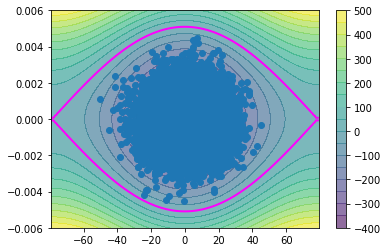

In [16]:
sigma_dp = rfbucket.dp_max(sigma_z) # same Hamiltonian value for both sigma_dp and sigma_z

dist = generators.gaussian2D_asymmetrical(sigma_z, sigma_dp)
within_separatrix = rfbucket.make_is_accepted()
distribution_z = generators.cut_distribution(dist, within_separatrix)

bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=distribution_z,
).generate()

plot_long_phase_space(bunch_new, rfbucket)

print('emittance z:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})\n\n'.format(epsn_z))

### Margin within RF bucket matching

Macro-particles can get initialised too close to the bucket boundary in longitudinal phase space. For non-linear longitudinal kick-drift tracking as in the `RFSystems` class, this could result in particles exiting the RF bucket because the separatrix is strictly defined for the smooth Hamiltonian (whose equation of motion are only approximately solved with the kick-drift scheme). When restricting particle generating to within a bucket area, one might therefore add some margin around the separatrix. In the case of `cut_distribution`, its argument `margin` implements this.

For convenience, the `RF_bucket_distribution` supports `margin` as a kwarg for the case of generating a thermal longitudinal distribution as well:

*** Maximum RMS emittance 4.505891675377581eV s.
... distance to target emittance: -1.19e+00
... distance to target emittance: 2.78e+00
... distance to target emittance: 1.45e+00
... distance to target emittance: 1.09e-01
... distance to target emittance: -5.53e-03
... distance to target emittance: 1.60e-06
... distance to target emittance: -4.74e-06
--> Emittance: 1.2000016025417657
--> Bunch length: 11.8086739325653
emittance z: 1.2146007764357007 (nominal value: 1.2)




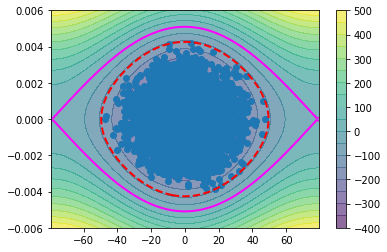

In [17]:
cutting_margin = 0.3

distribution_z = generators.RF_bucket_distribution(
    rfbucket, epsn_z=epsn_z, margin=cutting_margin)

bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=distribution_z,
).generate()

plot_long_phase_space(bunch_new, rfbucket, margin=cutting_margin)

print('emittance z:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})\n\n'.format(epsn_z))

### Limit for linear Gaussian matching

For linear matching, if the longitudinal phase space is populated with a thermal (Gaussian) distribution, the macro-particles are not limited to a region: they can be located anywhere in the phase space plane with a synchrotron amplitude between $[0, \infty)$. It may be useful to restrict the particle distribution within a finite region in phase space (otherwise particles could be located outside e.g. a fixed slicing region and not be taken into account for wake fields or space charge). 

emittance z: 1.1459143567652463 (nominal value: 1.2)




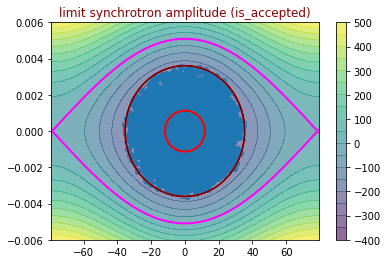

In [18]:
limit_n_rms = 3
factor_smaller = 1

epsn_z_small = epsn_z / factor_smaller
sigma_z_small = sigma_z / np.sqrt(factor_smaller)

beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
egeoz_small = epsn_z_small * e / (4 * np.pi * p0)

is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=1/np.sqrt(beta_z) * sigma_z_small,
    limit_n_rms=limit_n_rms,
)

distribution_z = generators.cut_distribution(
    distribution=generators.gaussian2D(egeoz_small),
    is_accepted=is_accepted
)

bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_z=distribution_z,
    eta=eta, Qs=Qs,
).generate()

plot_long_phase_space(bunch_new, rfbucket)

X, Y = np.meshgrid(np.linspace(*plt.xlim(), num=1000), 
                   np.linspace(*plt.ylim(), num=1000))
plt.contour(X, Y, is_accepted(X / np.sqrt(beta_z), Y * np.sqrt(beta_z)),
            cmap=plt.get_cmap('Reds'))
plt.title('limit synchrotron amplitude (is_accepted)', color='darkred')

ep = patches.Ellipse((0, 0), 2 * sigma_z_small, 2 * epsn_z_small * e / (4*np.pi * p0 * sigma_z_small),
                    linewidth=2, fill=False, color='red', zorder=20)
plt.gca().add_patch(ep)

print('emittance z:', bunch_new.epsn_z(), 
      '(nominal value: {0:.3g})\n\n'.format(epsn_z_small))

$\implies$ note that the darkred line indicating the cutting limit at 3 RMS emittances deviates from the (non-linearly distorted) iso-Hamiltonian contours.